In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import shap

import warnings
warnings.filterwarnings('ignore')

C:\Users\213061\Anaconda3\envs\test_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

In [4]:
def Draw_graph(model, X_train, X_test, y_train, y_test):
    
    X_pred = model.predict(X_test)
    
    # Precision and Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, X_pred)
    average_precision = average_precision_score(y_test, X_pred)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
    
    ax1.step(recall, precision, color='k', alpha=0.7, where='post')
    ax1.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlim([0.0, 1.0])
    
    ax1.set_title('Precision-Recall curve : Average Precision = {0:0.2f}'.format(average_precision))
    
    # Roc_curve 
    fpr, tpr, thresholds = roc_curve(y_test, X_pred)
    areaUnderROC = auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, color='r', lw=2, label='ROC Cureve')
    ax2.plot([0,1],[0,1], color='k',lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    ax2.legend(loc='lower right')
    plt.show()

# Model with normal 30000 data

In [5]:
# Data import
CustNo = pd.read_pickle('./data_tmp/CustNo3.pkl')
Dt = pd.read_pickle('./data_tmp/Dt3.pkl')
final_df = pd.read_pickle('./data_tmp/final_df3.pkl')
Label = pd.read_pickle('./data_tmp/Label3.pkl')

Dp_list = Dt.duplicated()

CustNo = CustNo[~Dp_list]
Dt = Dt[~Dp_list]
final_df = final_df[~Dp_list]
Label = Label[~Dp_list]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, Label, test_size=.2)

In [44]:
# Decision Tree
DT_clf = DecisionTreeClassifier()

parameters = {'max_depth':[6,8,10,12,14]}
DT_clf = RandomizedSearchCV(DT_clf, parameters, scoring='f1',n_iter=100)
DT_clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'max_depth': [6, 8, 10, 12, 14]},
                   scoring='f1')

In [45]:
DT_clf.best_params_

{'max_depth': 14}

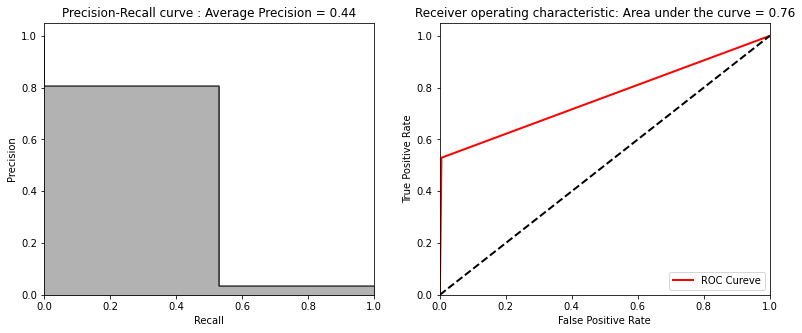

In [46]:
# Decision graph draw
Draw_graph(DT_clf, X_train, X_test, y_train, y_test)

In [47]:
DT_clf = DecisionTreeClassifier(**DT_clf.best_params_)

In [49]:
DT_clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=14)

In [53]:
explainer = shap.TreeExplainer(DT_clf)
shap_values = explainer.shap_values(X_test)

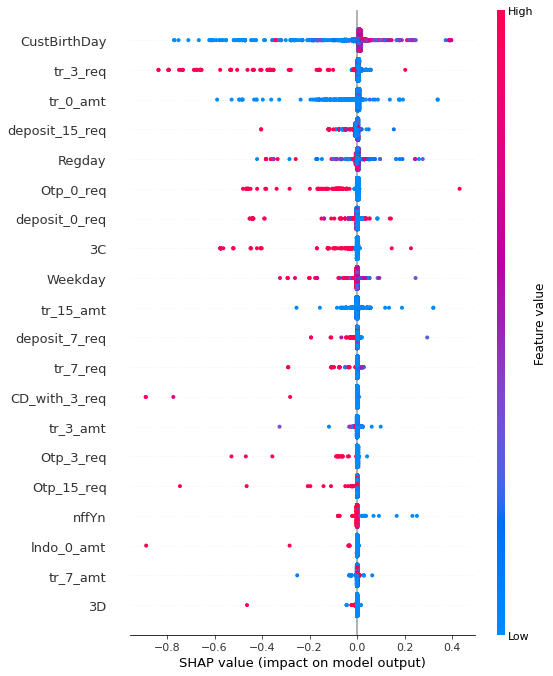

In [54]:
shap.summary_plot(shap_values[0], X_test, feature_names=final_df.columns)

In [55]:
# Random Forest Classifier
RF_clf = RandomForestClassifier()

parameters = {'n_estimators':[8,10,20,50,100],'max_depth':[6,8,10,12,14,16],'max_features':[30,34,38,43],'n_jobs':[-1]}
RF_clf = RandomizedSearchCV(RF_clf, parameters, scoring='f1',n_iter=100)
RF_clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [6, 8, 10, 12, 14, 16],
                                        'max_features': [30, 34, 38, 43],
                                        'n_estimators': [8, 10, 20, 50, 100],
                                        'n_jobs': [-1]},
                   scoring='f1')

In [56]:
RF_clf.best_params_

{'n_jobs': -1, 'n_estimators': 100, 'max_features': 38, 'max_depth': 16}

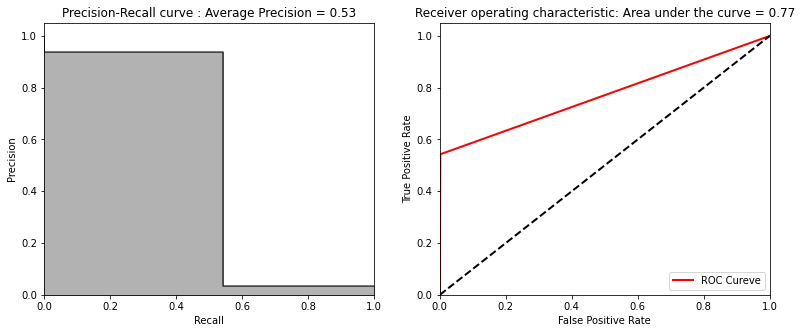

In [57]:
# Random Forest graph draw
Draw_graph(RF_clf, X_train, X_test, y_train, y_test)

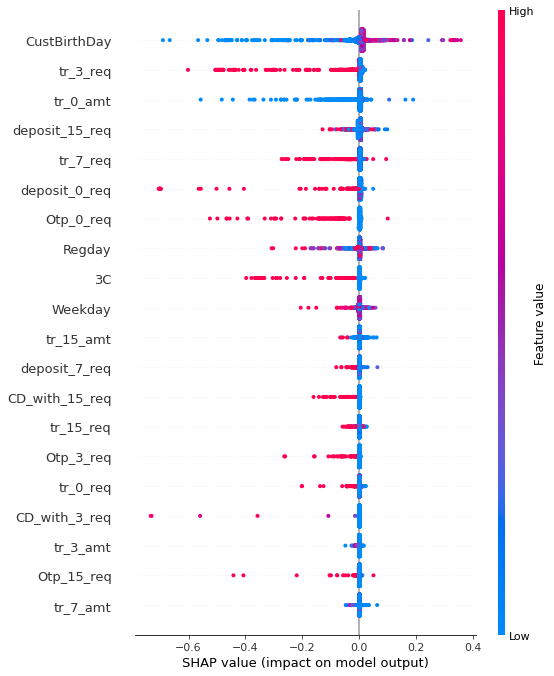

In [58]:
RF_clf = RandomForestClassifier(**RF_clf.best_params_)
RF_clf.fit(X_train,y_train)

explainer = shap.TreeExplainer(RF_clf)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, feature_names=final_df.columns)

In [59]:
# LGBM Classifier
lgb_clf = LGBMClassifier()

parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2], 'reg_alpha':[0,0.01,0.03],'num_iterations':[100,120,140,160,180,200]}

lgb_clf = RandomizedSearchCV(lgb_clf, parameters, scoring='f1',n_iter=100)
lgb_clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=LGBMClassifier(), n_iter=100,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [-1, 5, 10, 20],
                                        'min_child_samples': [5, 10, 15],
                                        'num_iterations': [100, 120, 140, 160,
                                                           180, 200],
                                        'num_leaves': [20, 40, 60, 80, 100],
                                        'reg_alpha': [0, 0.01, 0.03]},
                   scoring='f1')

In [60]:
lgb_clf.best_params_

{'reg_alpha': 0,
 'num_leaves': 100,
 'num_iterations': 160,
 'min_child_samples': 10,
 'max_depth': -1,
 'learning_rate': 0.2}

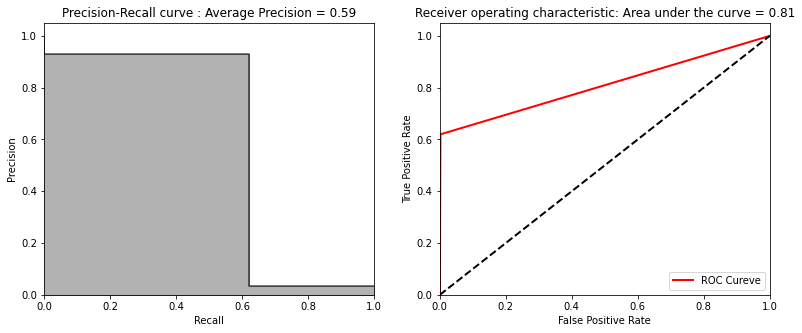

In [61]:
# Random Forest graph draw
Draw_graph(lgb_clf, X_train, X_test, y_train, y_test)

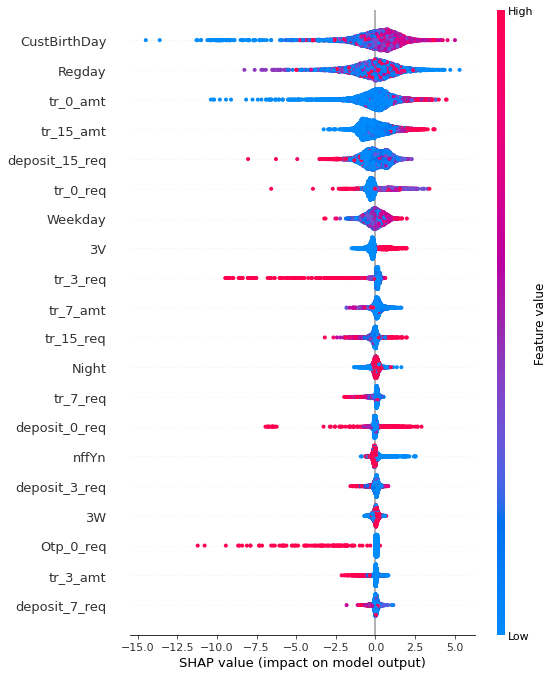

In [62]:
lgb_clf = LGBMClassifier(**lgb_clf.best_params_)
lgb_clf.fit(X_train,y_train)

explainer = shap.TreeExplainer(lgb_clf)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, feature_names=final_df.columns)

In [ ]:
# XGBClassifier
XGB_clf = XGBClassifier(verbose=0)

parameters = {'n_estimators':list(range(100,1000,100)), 'learning_rate':np.arange(0,1,0.1),'max_depth':list(range(3,16))}

XGB_clf = RandomizedSearchCV(XGB_clf, parameters, scoring='f1',n_iter=100)
XGB_clf.fit(X_train, y_train)

[13:34:31] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:34:31] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:32] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but ge

[13:35:01] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:35:01] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but ge

[13:35:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:35:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:37] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but ge

[13:36:22] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:36:22] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:28] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but ge

[13:37:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:37:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
XGB_clf.best_params_

In [ ]:
Draw_graph(XGB_clf, X_train, X_test, y_train, y_test)

In [ ]:
XGB_clf = XGBClassifier(**XGB_clf.best_params_)
XGB_clf.fit(X_train,y_train)

In [ ]:
explainer = shap.TreeExplainer(XGB_clf)

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=final_df.columns)